In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Unlabeled Data

   Unnamed: 0         _start          _stop          _time  Area  ErrorCode  \
0           0  1701262800000  1701266399999  1701263293436    99          0   
1           1  1701262800000  1701266399999  1701263311643    99          0   
2           2  1701262800000  1701266399999  1701263345644    99          0   
3           3  1701262800000  1701266399999  1701263367394    99          0   
4           4  1701262800000  1701266399999  1701263387177    99          0   

   FunctionalUnit    Geohash  Line  Measurement  ... SystemIndex  \
0               2  ezjqj2by2  4104  WireCutting  ...           1   
1               2  ezjqj2by2  4104  WireCutting  ...           1   
2               2  ezjqj2by2  4104  WireCutting  ...           1   
3               2  ezjqj2by2  4104  WireCutting  ...           1   
4               2  ezjqj2by2  4104  WireCutting  ...           1   

   ToolPosition      TypeID      WPC WorkPosition  _measurement  \
0             1  1134240024  Def WPC          300

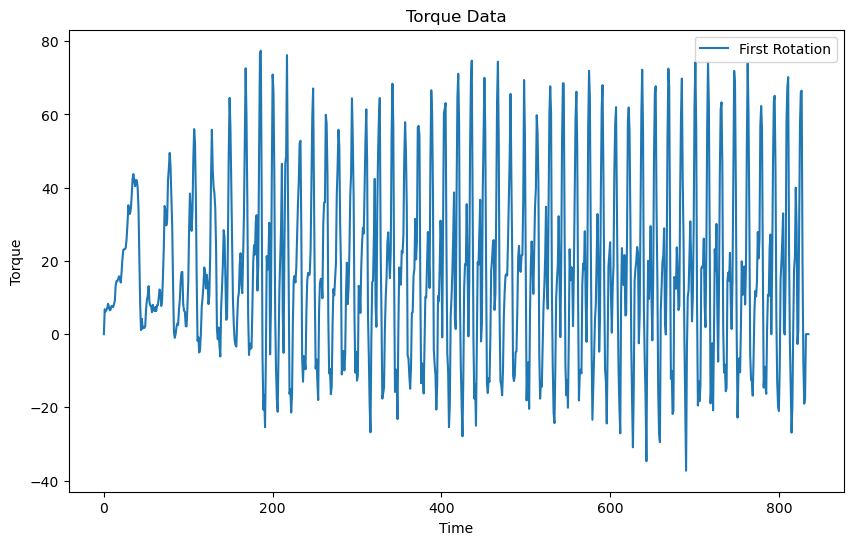

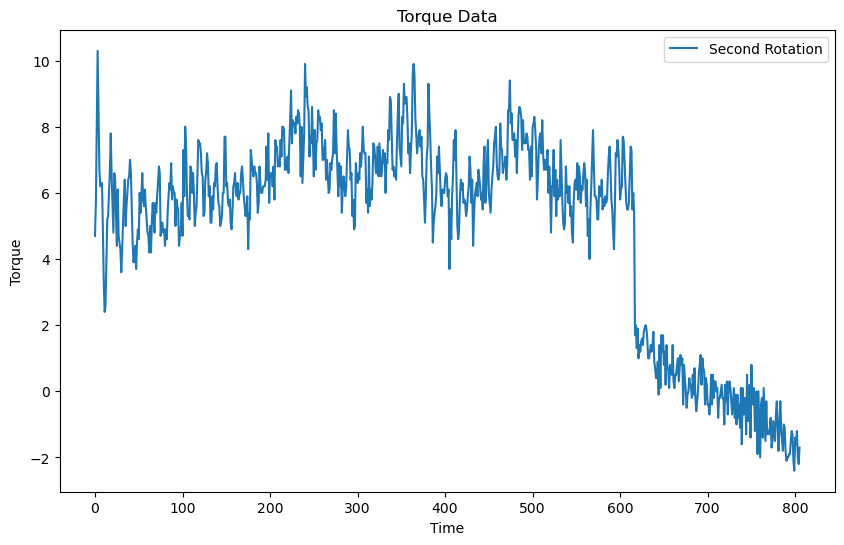

In [2]:

# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
nr_rows = 30000
df = pd.read_csv('all.csv', nrows=nr_rows)
print(df.head())
# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

torque_array = []
whole_rotation = []
first_rotation = []
second_rotation = []

for sample in range(0, nr_rows):
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"])
    torque = torque.drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    resultat = total_data[total_data['Kumulatives_Produkt'] == 1]
    resultat2 = total_data[total_data['Kumulatives_Produkt'] == 0]
    resultat2 = resultat2.reset_index()

    resultat = resultat.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    resultat2 = resultat2.drop(columns=["Time", "index", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])

    # Ensure both dataframes have the same shape by truncating or padding
    whole_len = 1800
    max_len = 836  # Define the target length
    resultat = resultat.head(max_len).reindex(range(max_len), fill_value=0)
    resultat2 = resultat2.head(max_len).reindex(range(max_len), fill_value=0)


    first_rotation.append(resultat)
    second_rotation.append(resultat2[30:836])

    total_data = total_data.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    total_data = total_data.head(max_len).reindex(range(whole_len), fill_value=0)
    whole_rotation.append(total_data)

    torque_array.append(torque)

# First Rotation
data = np.array(first_rotation)
squeezed_arr = np.squeeze(data)

# Second Rotation - The rotatiion where Frequencies are different
data2 = np.array(second_rotation)
squeezed_arr2 = np.squeeze(data2)

# Whole Rotation
data3 = np.array(whole_rotation)
whole_rotation_arr = np.squeeze(data3)

# FIXME: How to extract the cutting data from the whole rotation data without rel_time
# Plotting the first sample
#time_vector = np.arange(len(whole_rotation_arr[10])) * 0.002
plt.figure(figsize=(10, 6))
plt.plot(squeezed_arr[10], label='First Rotation')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.title('Torque Data')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(squeezed_arr2[10], label='Second Rotation')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.title('Torque Data')
plt.legend()
plt.show()

# Extract the Cutting Part of the First Rotation

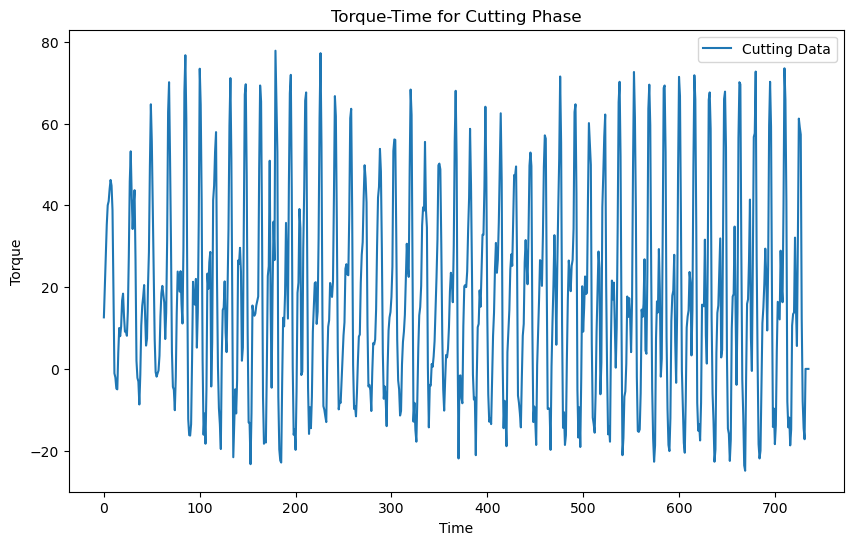

In [3]:
all_cutting_data = []
for sample in squeezed_arr:
    cutting_data = sample[100:836]
    all_cutting_data.append(cutting_data)

# plot the first cutting data
plt.figure(figsize=(10, 6))
plt.plot(all_cutting_data[0], label='Cutting Data')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.title('Torque-Time for Cutting Phase')
plt.legend()
plt.show()

## Extract Scalograms

In [4]:
import pywt
import cv2

scalogram_features = list()
scale_resolution = 24

def compute_scalo_spectrogram(data, title, wavelet='cmor', cmap='magma'):
    scales = np.arange(1, scale_resolution)
    coefficients, frequencies = pywt.cwt(data, scales, wavelet)
    power = (abs(coefficients)) ** 2
    
    # Time vector just for plot
    #time_vector = np.arange(len(data)) * 0.002
    #print(power.shape, time_vector.shape, scales.shape)
    return power

#window = len(all_cutting_data[0])
window = 512

for i in range(len(all_cutting_data)):
    cutting_torque = all_cutting_data[i]
    scalo = compute_scalo_spectrogram(cutting_torque, 'cutting segment')
    scalo = scalo[:, :window]

    # Normalizing features
    scalo = cv2.normalize(scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    scalogram_features.append(scalo)


print(scalogram_features[2].shape)
    




/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


(23, 512)


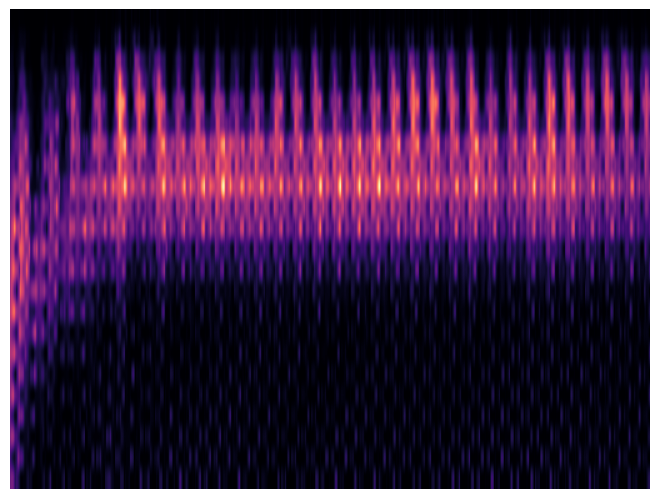

In [5]:
# Which Sample to View
S = 10
cmap = 'magma'
# Example to view one scalogram as an image using OpenCV
temp = np.asarray(scalogram_features[S])

# Normalize the data to 0-255 for display
temp_normalized = cv2.normalize(temp, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
temp_normalized = temp_normalized.astype(np.uint8)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(temp_normalized, cmap, aspect='auto')
plt.show()


## Define Model Architecture

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import torch
# Modify ResNet-18
class ResNet18MelSpectrogram(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18MelSpectrogram, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer before the fully connected layer
            nn.Linear(self.resnet.fc.in_features, 2)  # 2 classes: good and bad
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNet18MelSpectrogram()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('scalogram_model_ResNet18-2_98.66.pth'))
model.eval()

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_14069/2512103349.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `

ResNet18MelSpectrogram(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

## Dataloader for Large Unlabeled Data

### FIXME

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Custom Dataset class for unlabeled data
class UnlabeledSpectrogramDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        return torch.tensor(feature, dtype=torch.float32)

# Load your unlabeled data (replace with your loading logic)
unlabeled_features = scalogram_features

# Create unlabeled dataset
unlabeled_dataset = UnlabeledSpectrogramDataset(unlabeled_features)

# Create dataloader for unlabeled data
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

predicted_labels = []

if torch.cuda.is_available():
    model.cuda()

with torch.no_grad():
    for features in unlabeled_loader:
        features = features.unsqueeze(1).to(device)
        outputs = model(features)
        #print(outputs)
        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(outputs, dim=1)
        print(probabilities)
        # Get the predicted class (0 for bad, 1 for good)
        _, predicted = torch.max(probabilities, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())

# Count the number of good and bad predictions
good_count = predicted_labels.count(1)
bad_count = predicted_labels.count(0)

print("Good:", good_count)
print("Bad:", bad_count)


tensor([[0.0089, 0.9911],
        [0.0116, 0.9884],
        [0.0107, 0.9893],
        [0.0107, 0.9893],
        [0.0120, 0.9880],
        [0.0104, 0.9896],
        [0.0109, 0.9891],
        [0.0088, 0.9912],
        [0.0094, 0.9906],
        [0.0100, 0.9900],
        [0.0096, 0.9904],
        [0.0099, 0.9901],
        [0.0092, 0.9908],
        [0.0102, 0.9898],
        [0.0115, 0.9885],
        [0.0110, 0.9890],
        [0.0084, 0.9916],
        [0.0102, 0.9898],
        [0.0112, 0.9888],
        [0.0100, 0.9900],
        [0.0107, 0.9893],
        [0.0106, 0.9894],
        [0.0093, 0.9907],
        [0.0113, 0.9887],
        [0.0114, 0.9886],
        [0.0089, 0.9911],
        [0.0094, 0.9906],
        [0.0087, 0.9913],
        [0.0105, 0.9895],
        [0.0104, 0.9896],
        [0.0083, 0.9917],
        [0.0111, 0.9889]], device='cuda:0')
tensor([[0.0129, 0.9871],
        [0.0092, 0.9908],
        [0.0099, 0.9901],
        [0.0101, 0.9899],
        [0.0107, 0.9893],
        [0.0092, 0.9

: 